### 9-2. RNN を使って sin波を予測してみよう
実際に簡単な RNN の Network を作り、予測をしていく

csv File を読み込む

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import os

In [2]:
# Seed固定
seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

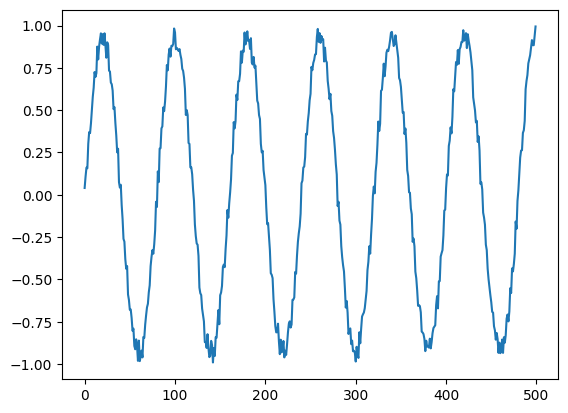

In [3]:
data = np.loadtxt("./rnn_sin_40_80.csv")  # 波形Data を読み込み
plt.plot(data[:500])  # 読み込んだ Data の500番目までを plot
plt.show()

#### 学習用と検証用に Data を分ける
RNN は過去のいくつかの Data から未来のいくつかの Data を予測するため、学習と検証に使う Data をそれぞれ加工していく必要がある。

In [6]:
def create_dataset(data, history_steps, future_steps):
    """
    history_steps Step数を入力に使い、future_steps Step数を予測するように加工する
    """
    input_data = []
    output_data = []

    for i in range(len(data) - history_steps - future_steps):
        input_data.append([[val] for val in data[i:i + history_steps]])
        output_data.append(data[i + history_steps:i + history_steps + future_steps])

    return np.array(input_data), np.array(output_data)

In [7]:
# Data を75%を学習用、25%を検証用に分割
train_data = data[:int(len(data) * 0.75)]
test_data = data[int(len(data) * 0.75):]

# 10 Step分の Data から 5 Step未来までを予測するような Data を作成する
history_steps = 10  # 学習を行なう Step数
future_steps = 5  # 予測を行なう Step数
x_train, y_train = create_dataset(train_data, history_steps, future_steps)
x_test, y_test = create_dataset(test_data, history_steps, future_steps)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2385, 10, 1)
(2385, 5)
(785, 10, 1)
(785, 5)


RNN を用いた予測を実行する

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam

In [10]:
# Model の構築
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=future_steps, input_shape=(history_steps, 1), return_sequences=False))
model_rnn.add(Dense(future_steps, activation="linear"))
model_rnn.compile(optimizer=Adam(lr=0.001), loss="mean_squared_error", )

# Model の構築を表示する
print(model_rnn.summary())

# 学習開始
history = model_rnn.fit(x_train, y_train, batch_size=32, epochs=500, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 5)                 35        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
75/75 [==============================] - 1s 2ms/step - loss: 0.5609
Epoch 2/500
75/75 [==============================] - 0s 2ms/step - loss: 0.3449
Epoch 3/500
75/75 [==============================] - 0s 2ms/step - loss: 0.2712
Epoch 4/500
75/75 [==============================] - 0s 2ms/step - loss: 0.2189
Epoch 5/500
75/75 [==============================] - 0s 2ms/step - loss: 0.1764
Epoch 6/500
75/75 [==============================

### 9-3. 予測した結果を評価してみよう
RNN を用いた予測Data を実際に確認し、その評価を行なっていく。

予測結果と実際の Data を同じ Graph に表示する

25/25 [==============================] - 0s 1ms/step


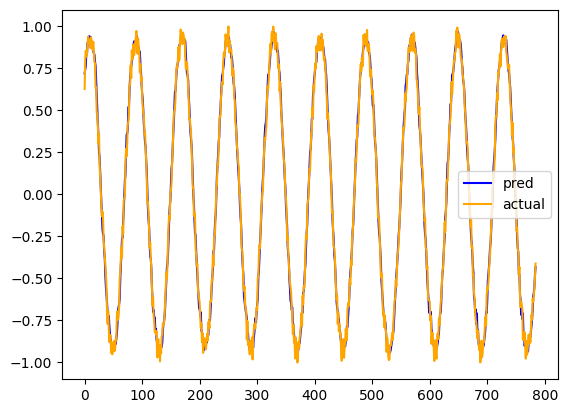

In [11]:
# 学習した Model で予測する
y_pred = model_rnn.predict(x_test)

# 青色で予測値、オレンジ色で実際の値を表示
plt.plot([p[0] for p in y_pred], color="blue", label="pred")
plt.plot([p[0] for p in y_test], color="orange", label="actual")
plt.legend()
plt.show()

実際の値と予測値はかなり近いことがわかる。
初期の 10step 以降の実際の値は一切使わずにどこまで予測できるか見てみる。

４Step目で予測した値と実際の値を同じ Graph で表示する。

In [12]:
# 学習済み Model と予測に用いる値、実際の値の３つを引数に取る
def predict_all(model, x_test, y_test):

    # 最初の history_steps分だけ利用する
    x_tmp = x_test[0]
    pred_result = []
    for index in range(len(y_test)):
        # x_tmp に入ってる Data で予測をする
        pred = model.predict(np.array([x_tmp]))

        # x_tmp の最初の Data を削除して、末尾に今回予測した Data の最初の１つを追加する
        x_tmp = np.append(x_tmp[1:,], pred[0][0].reshape(1, 1), axis=0)
        pred_result.append(pred[0][0])

    plt.figure(figsize=(30, 15))
    # 予測した値と実際の値を表示する
    plt.plot(pred_result, color="blue", label="pred")
    plt.plot([p[0] for p in y_test], color="orange", label="actual")
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 18ms/step


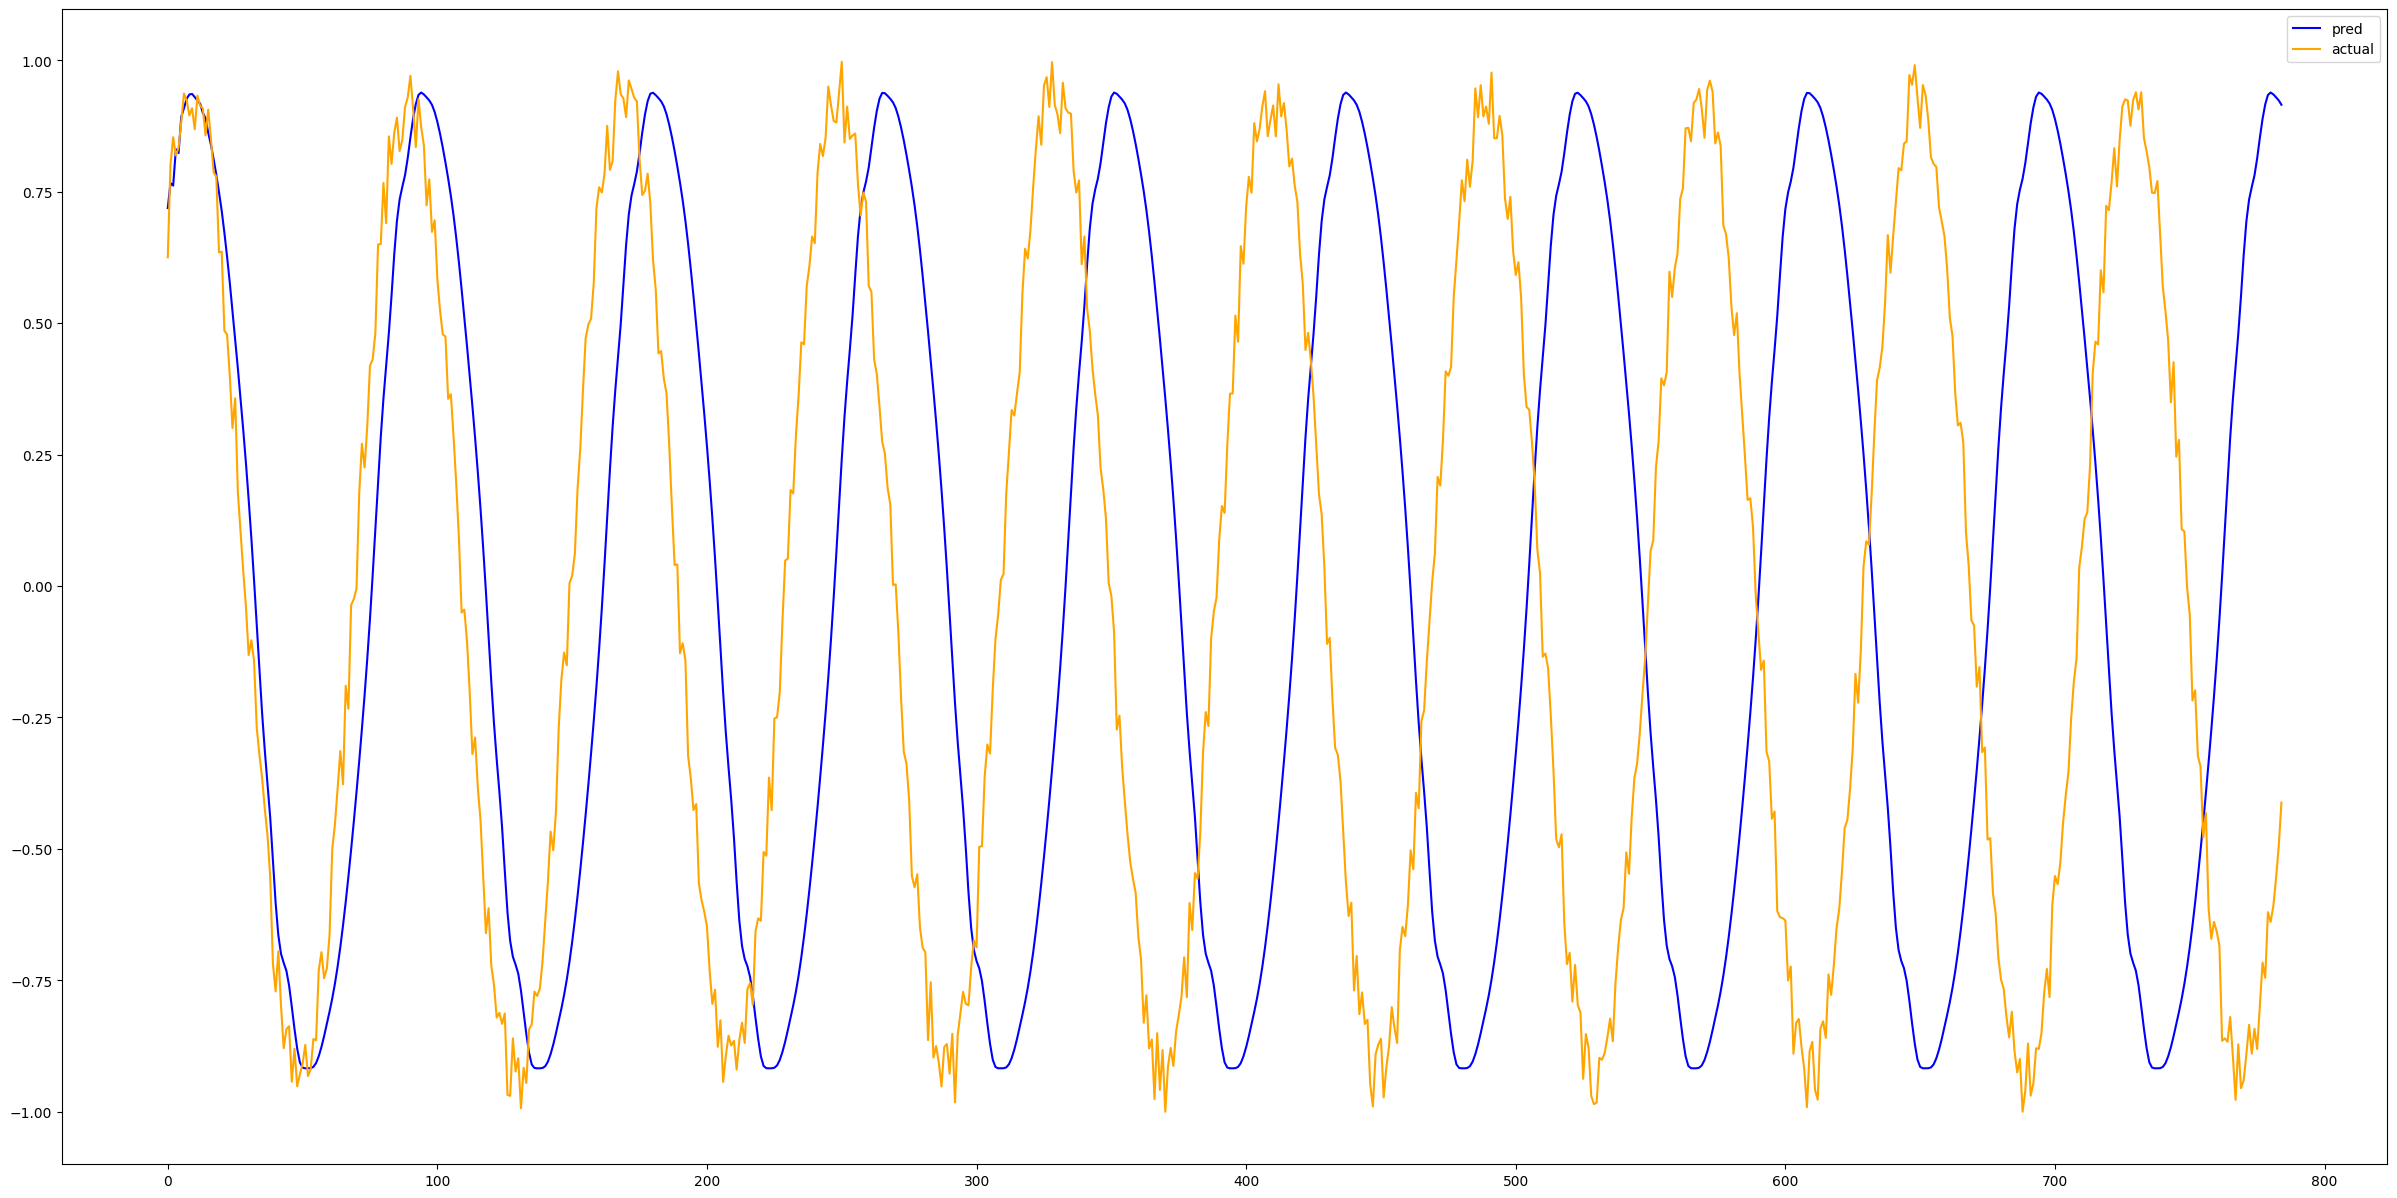

In [13]:
# 予測開始
predict_all(model_rnn, x_test, y_test)

実際の値と予測値を比較すると、予測精度はあまり高くない。

### 9-4. CNN を用いて sin波を予測してみよう
CNN でも時系列Data の予測が可能。Simple な Network を作ってみる。

Model の構築と学習

In [14]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [15]:
# Model の構築
model_conv = Sequential()
model_conv.add(
    Conv1D(filters=64, kernel_size=4, strides=1, padding="same", input_shape=x_train.shape[1:], activation="relu"))
model_conv.add(Conv1D(filters=128, kernel_size=4, strides=1, padding="same", activation="relu"))
model_conv.add(GlobalMaxPooling1D())
model_conv.add(Dense(future_steps, activation="tanh"))
model_conv.compile(optimizer=Adam(lr=0.001), loss="mean_squared_error")

In [16]:
# Model の構築を表示する
print(model_conv.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 64)            320       
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           32896     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 33,861
Trainable params: 33,861
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# 予測開始
history = model_conv.fit(x_train, y_train, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
75/75 [==============================] - 1s 2ms/step - loss: 0.1153
Epoch 2/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 3/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 4/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 5/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 6/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 7/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 8/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 9/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 10/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 11/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 12/50
75/75 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 13/50
75/75 [==============================

１つ先に Data を予測する

25/25 [==============================] - 0s 1ms/step


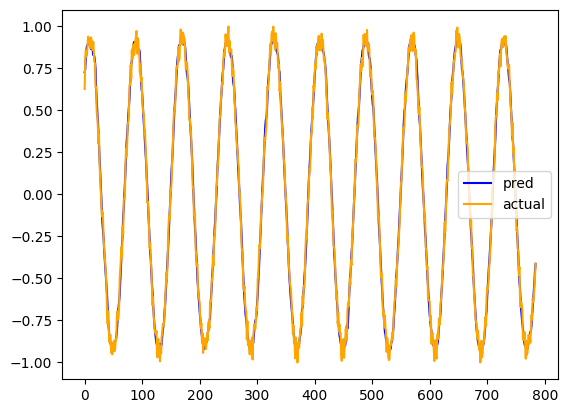

In [18]:
# 予測開始
y_pred = model_conv.predict(x_test)

plt.plot([p[0] for p in y_pred], color="blue", label="pred")
plt.plot([p[0] for p in y_test], color="orange", label="actual")
plt.legend()
plt.show()

RNN のときと同様に、かなり正確に予測できている。

10個の初期値からすべてを予測する

1/1 [==============================] - 0s 18ms/step


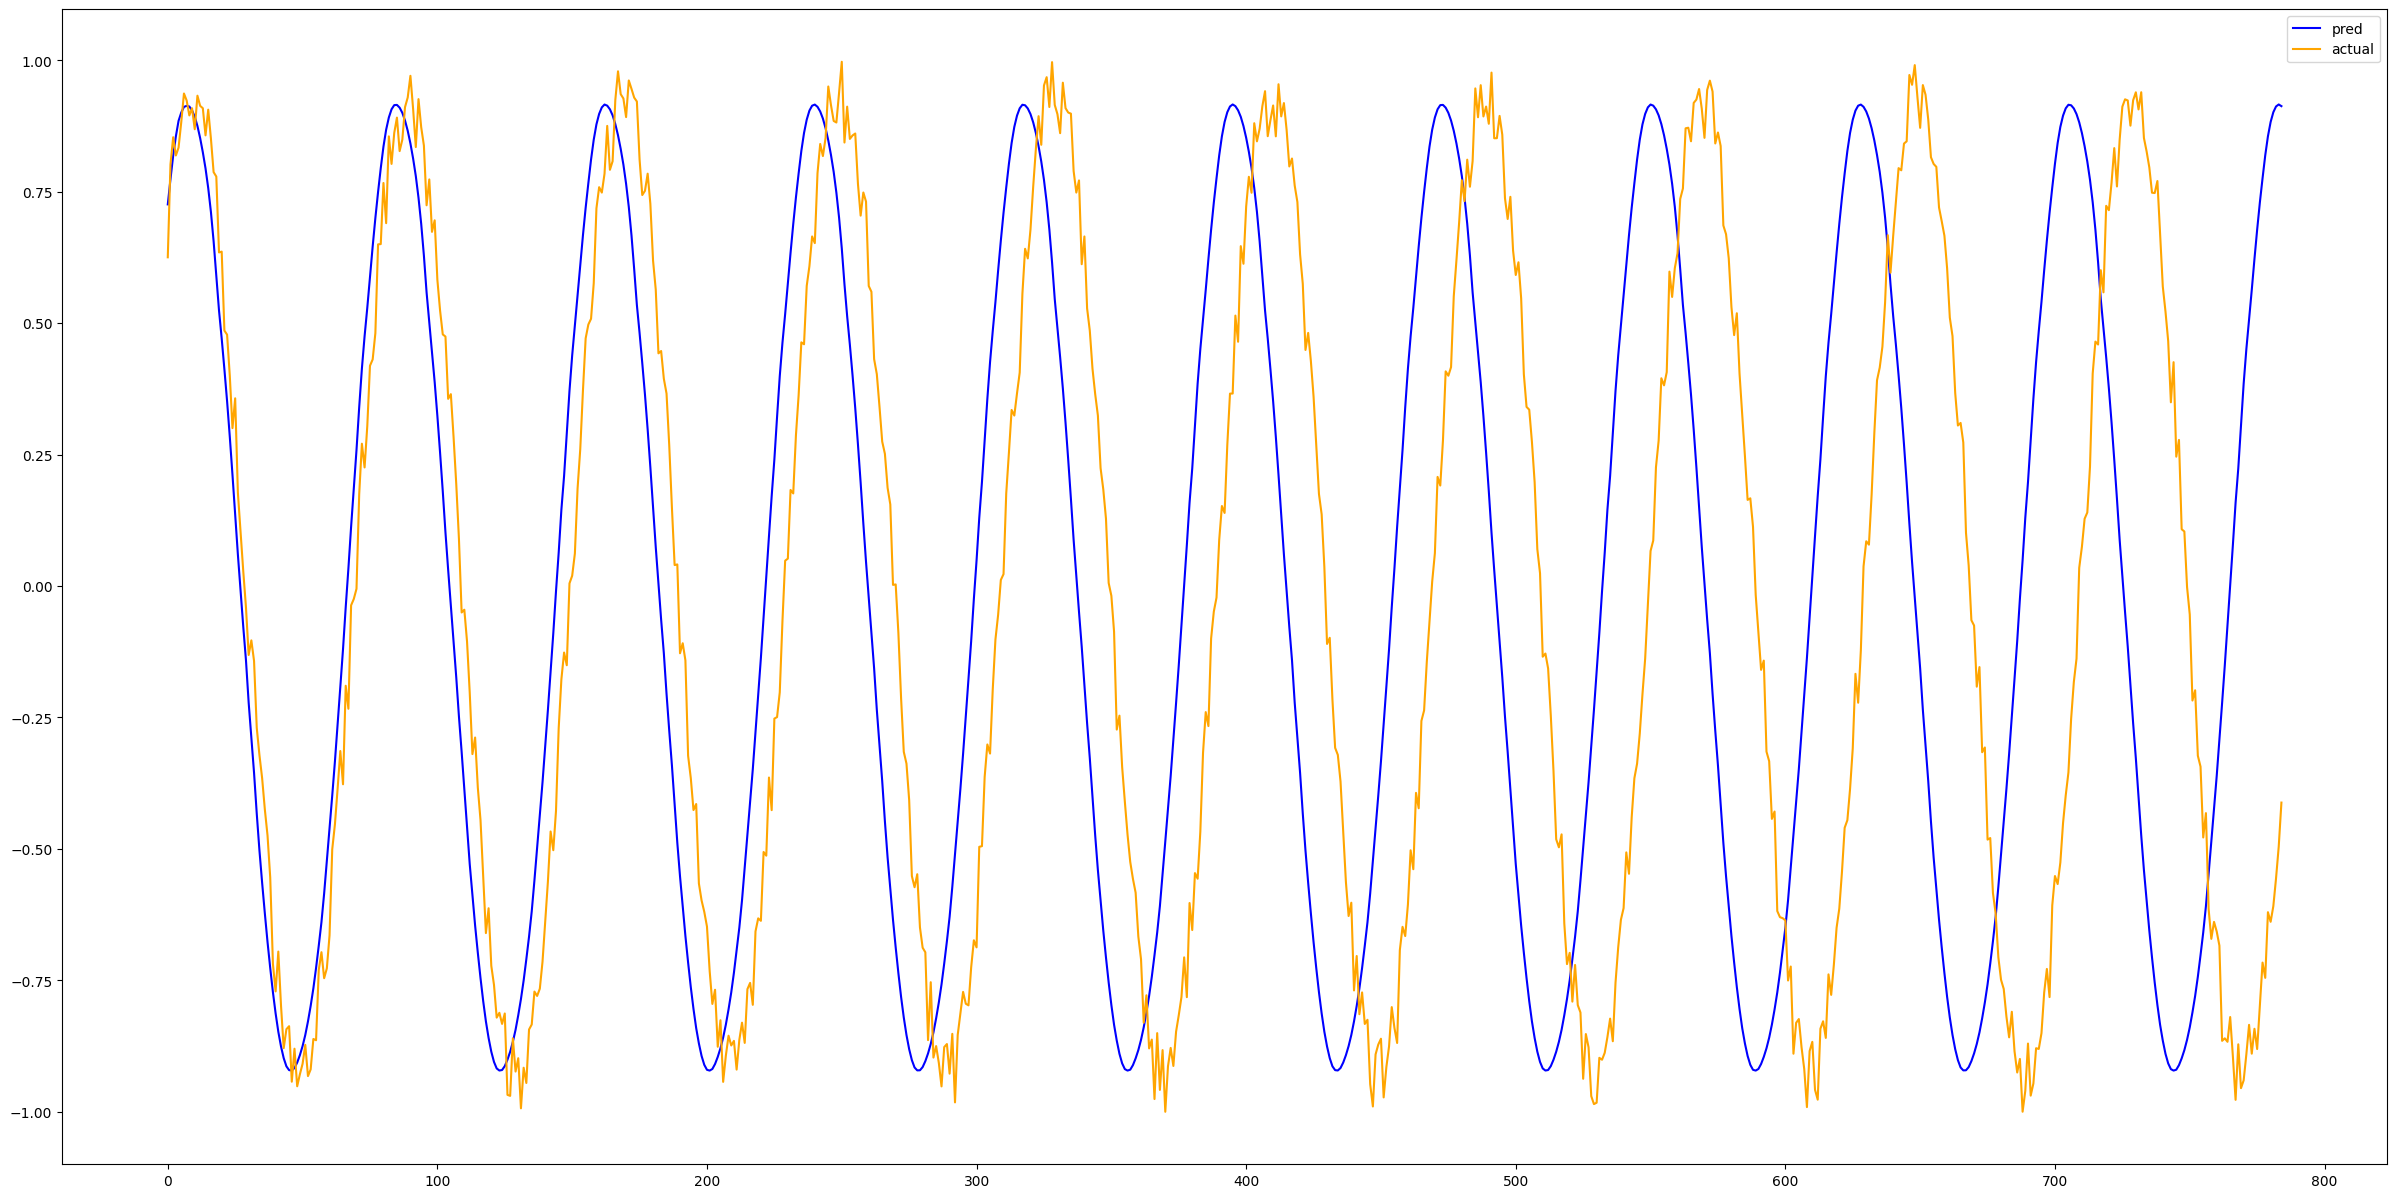

In [19]:
predict_all(model_conv, x_test, y_test)

RNN のときと同様に、横方向のズレが次第に大きくなってしまっている。

### 9-5. sin波の予測精度を高めよう
予測のために用いる期間（過去の Data の数）を変更することによって精度の向上を図る。

未来を予測する Data を作成する

In [20]:
# 過去の 40個の値から 10個の値を予測
history_steps_v2 = 40
future_steps_v2 = 10

# 40step分の Data から 10step 未来まで予測するような Data を作成する
x_train_v2, y_train_v2 = create_dataset(train_data, history_steps_v2, future_steps_v2)
x_test_v2, y_test_v2 = create_dataset(test_data, history_steps_v2, future_steps_v2)

print(x_train_v2.shape)
print(y_train_v2.shape)


(2350, 40, 1)
(2350, 10)


過去の 40個の値から 10個の値を予測する

In [23]:
# RNN の Model構築
model_rnn_v2 = Sequential()
model_rnn_v2.add(SimpleRNN(units=future_steps_v2, input_shape=(history_steps_v2, 1), return_sequences=False))
model_rnn_v2.add(Dense(future_steps_v2, activation="linear"))
model_rnn_v2.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

In [24]:
# Model の構築を表示する
print(model_rnn_v2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 230
Trainable params: 230
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# 学習開始
history = model_rnn_v2.fit(x_train_v2, y_train_v2, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
74/74 [==============================] - 1s 4ms/step - loss: 0.4442
Epoch 2/50
74/74 [==============================] - 0s 4ms/step - loss: 0.2109
Epoch 3/50
74/74 [==============================] - 0s 4ms/step - loss: 0.1063
Epoch 4/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0819
Epoch 5/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0686
Epoch 6/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0556
Epoch 7/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0433
Epoch 8/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0305
Epoch 9/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 10/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 11/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 12/50
74/74 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 13/50
74/74 [==============================

最初の 40個の値から予測する

1/1 [==============================] - 0s 16ms/step


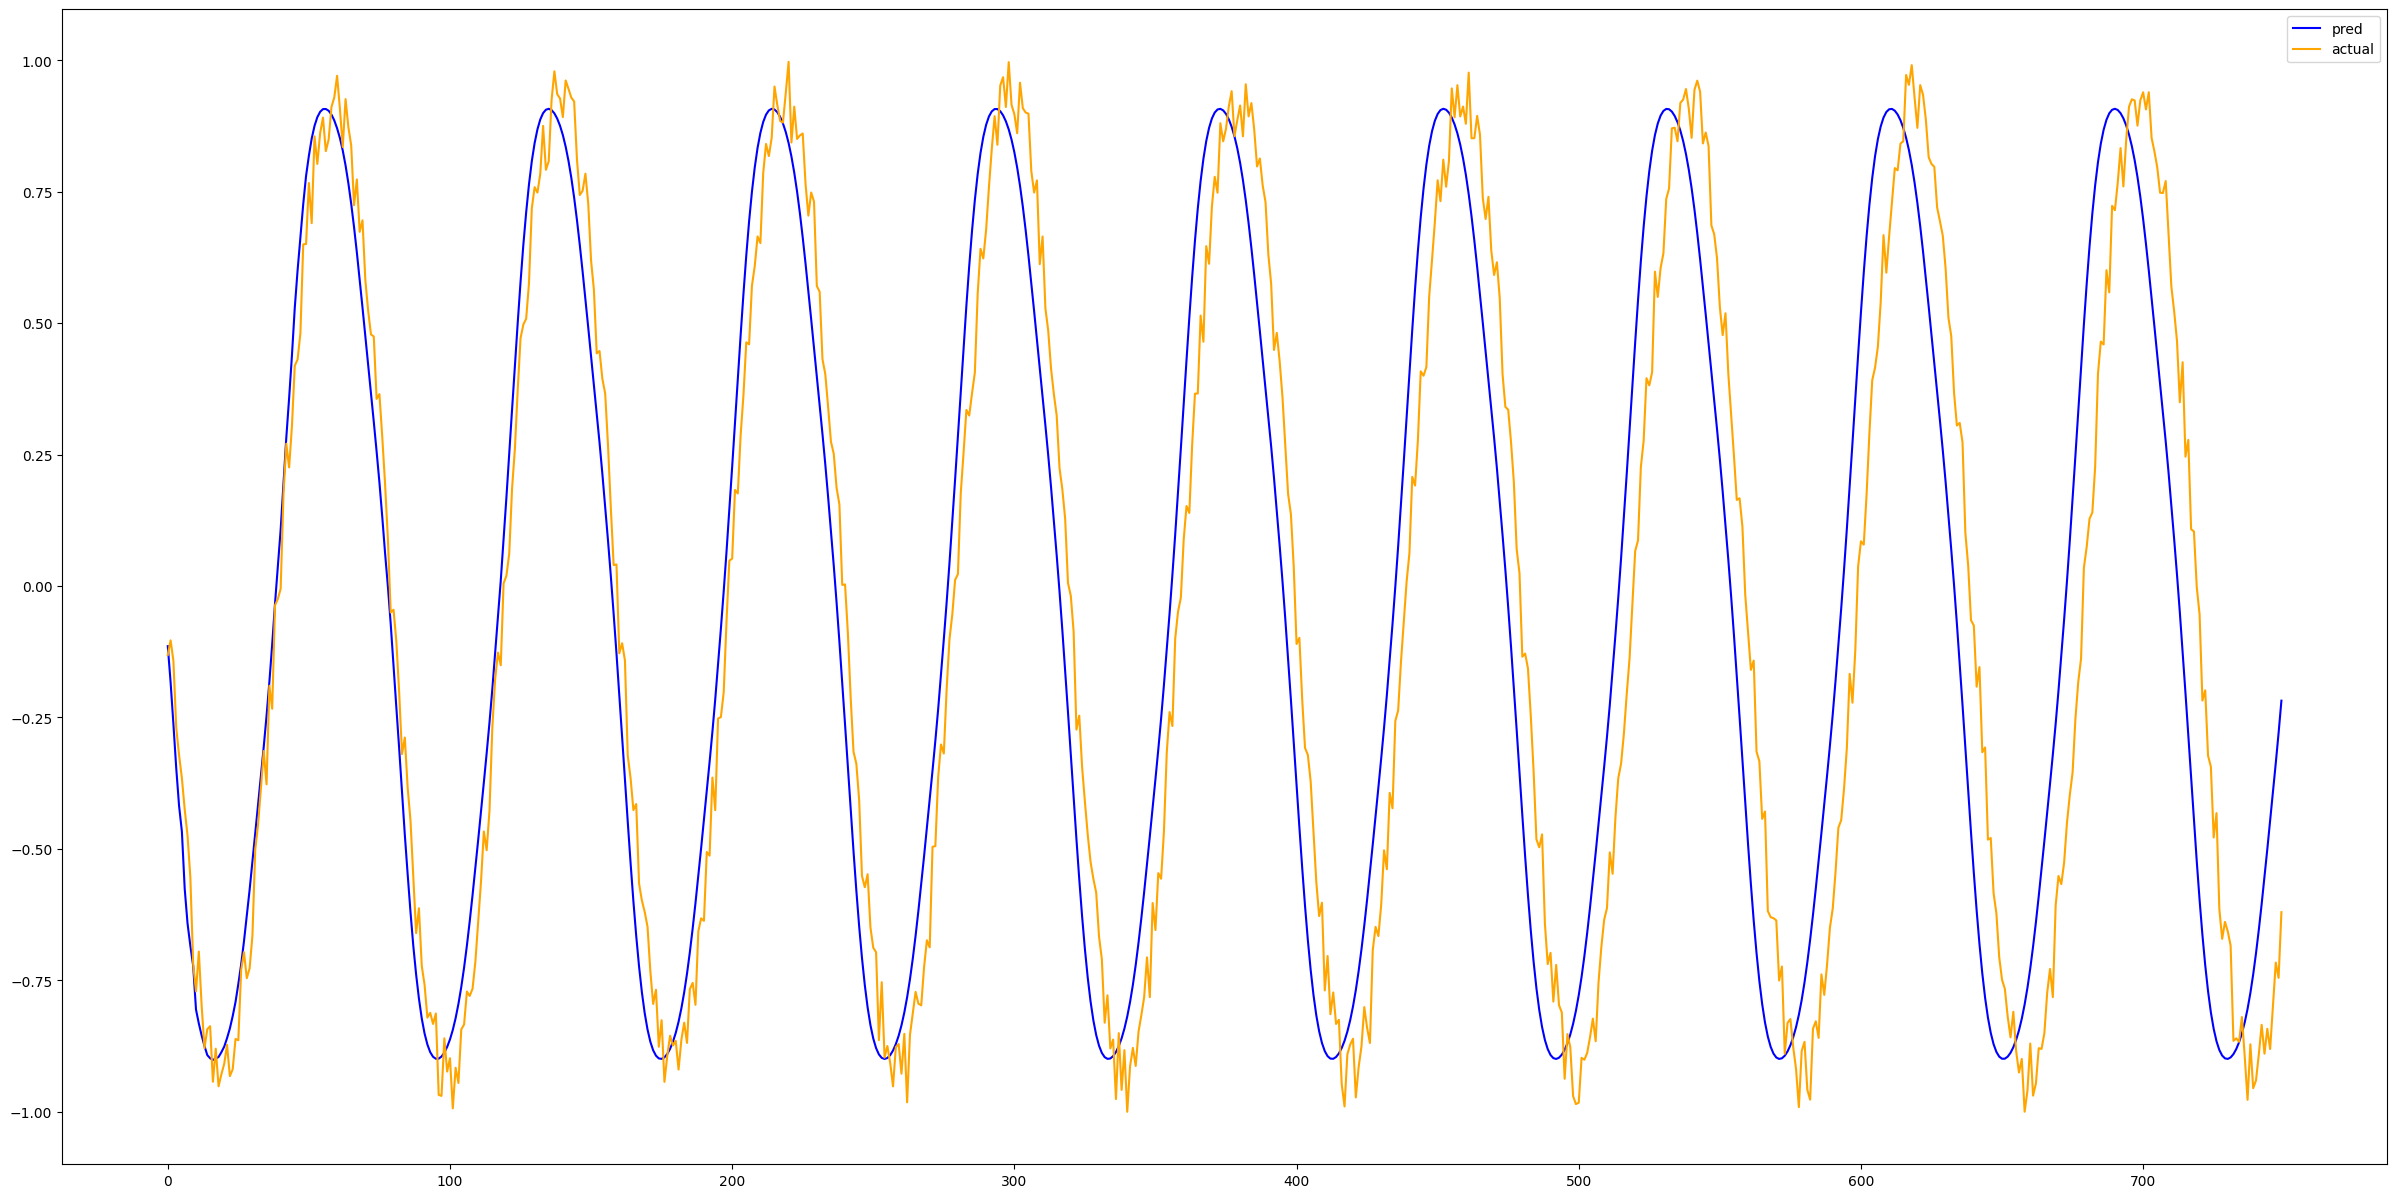

In [26]:
predict_all(model_rnn_v2, x_test_v2, y_test_v2)

期間を変えたうえで予測したことで予測精度が高まった。

CNN の Model を構築する

In [27]:
#CNN の Model を構築
model_conv_v2 = Sequential()
model_conv_v2.add(Conv1D(filters=64, kernel_size=4, strides=1, padding="same", input_shape=x_test_v2.shape[1:], activation="relu"))
model_conv_v2.add(Conv1D(filters=128, kernel_size=4, strides=1, padding="same", activation="relu"))
model_conv_v2.add(GlobalMaxPooling1D())
model_conv_v2.add(Dense(future_steps_v2, activation="tanh"))
model_conv_v2.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

In [28]:
# Model の構造を表示
print(model_conv_v2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 40, 64)            320       
                                                                 
 conv1d_3 (Conv1D)           (None, 40, 128)           32896     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
Total params: 34,506
Trainable params: 34,506
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
# 学習開始
history = model_conv_v2.fit(x_train_v2, y_train_v2, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
74/74 [==============================] - 1s 5ms/step - loss: 0.1395
Epoch 2/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 3/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 4/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 5/30
74/74 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 6/30
74/74 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 7/30
74/74 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 8/30
74/74 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 9/30
74/74 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 10/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 11/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 12/30
74/74 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 13/30
74/74 [==============================

最初の 40個の値から予測する

1/1 [==============================] - 0s 16ms/step


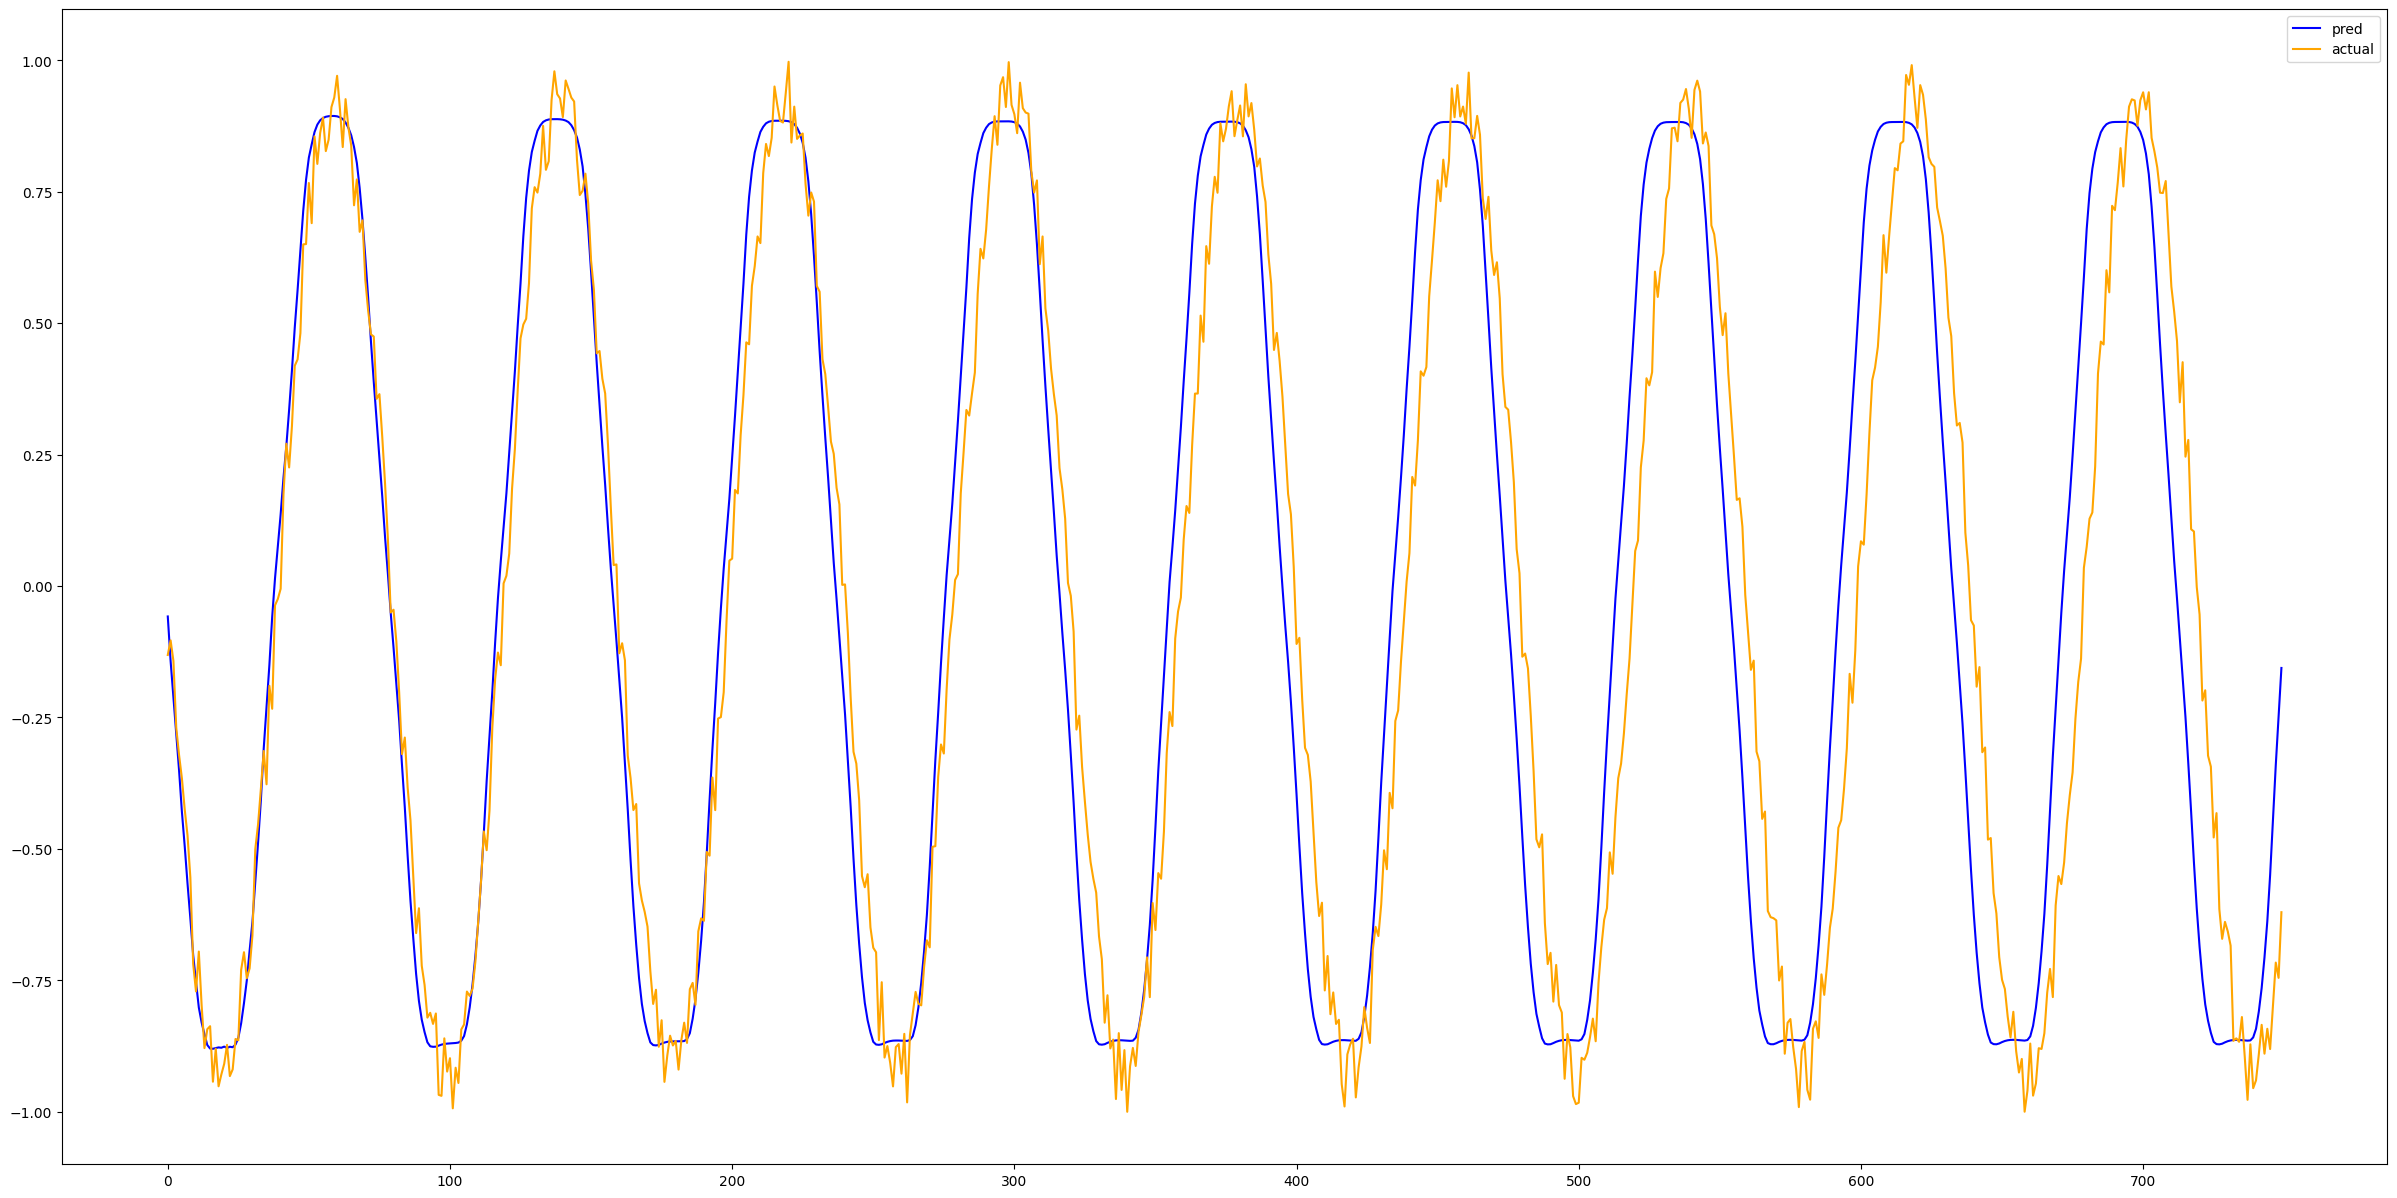

In [31]:
predict_all(model_conv_v2, x_test_v2, y_test_v2)

#### 予測精度を向上させる為の施策
- Network構造を変更する。
- 学習する Epoch数を変更する。
> ※重要
> Seed値を別のものに変更すると、結果が変わり得る。Seed値を変更して予測精度が下がれば、より精度が上がるような工夫を行なう必要がある。